## Quant dice game

You have a twenty-sided die that is initially showing a 1 on top. You also have 100 turns. Each turn, you must do exactly one of the following:
1. Take a number of dollars equal to the number showing on the top of the die
2. Re-roll the die

What is the optimal strategy for maximizing the amount of money you end up with?

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm

In [2]:
# Number of faces on our die
n_d = 20

In [3]:
def simulate(strat, n_turns=100, n_sims=10000, verbose=False):
    """
    Run Monte Carlo simulation of a strategy
        strat:      strategy function (top, remaining_turns) -> bool (whether to take)
        n_turns:    number of turns per game
        n_sims:     number of simulation runs
    """
    results = [0] * n_sims
    for i in tqdm(range(n_sims)) if verbose else range(n_sims):
        top = 1

        # Run single game
        for j in range(n_turns):
            action = strat(top, n_turns - j)
            if action:
                results[i] += top
            else:
                top = random.randrange(1, n_d + 1)
        
        # Normalize over number of turns
        results[i] /= n_turns

    return results

## Strategy 1: Take only if over certain threshold

In [4]:
def strat16(top, remaining_turns):
    return top >= 16

100%|██████████| 10000/10000 [00:00<00:00, 34641.45it/s]


Avg. winnings: 17.276


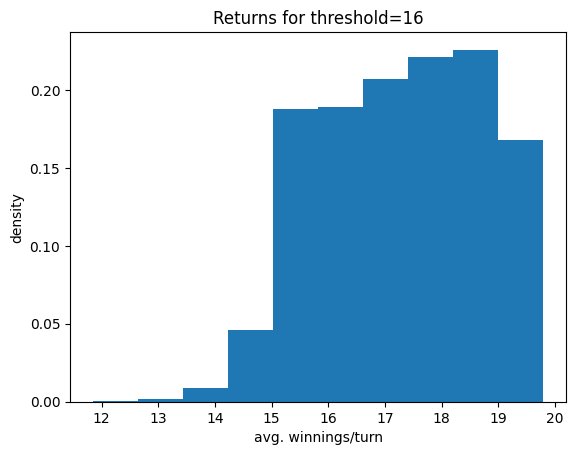

In [20]:
res16 = simulate(strat16, n_turns=100, n_sims=10000, verbose=True)
plt.hist(res16, 10, density=True)
plt.ylabel("density")
plt.xlabel("avg. winnings/turn")
plt.title(f"Returns for threshold={16}")
print(f"Avg. winnings: {np.mean(res16):.3f}")

In [6]:
res = []
for threshold in tqdm(range(15, n_d + 1)):
    # Run 10 trials of 1000-game sims per threshold
    for _ in range(10):
        mean = np.mean(simulate(lambda top, _: top >= threshold, n_turns=100, n_sims=1000))
        res.append([threshold, mean])

res = np.array(res)

100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Returns for threshold=18: 17.727


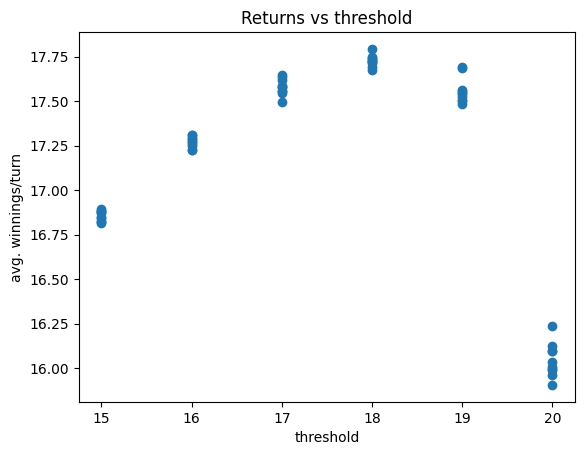

In [7]:
plt.scatter(*res.T)
plt.xlabel("threshold")
plt.ylabel("avg. winnings/turn")
plt.title("Returns vs threshold");
print(f"Returns for threshold=18: {np.mean(res[res[:,0] == 18][:,1]):.3f}")

## Strategy 2: dynamic programming

In [19]:
# Calculate exact EV for every state
dp = [[0] * (n_d + 1) for _ in range(101)]
dp_strat_table = [[None] * (n_d + 1) for _ in range(101)]

for rem_turns in range(1, 101):
    for top in range(1, n_d + 1):
        # If take, get top and EV if we keep top
        ev_take = top + dp[rem_turns - 1][top]
        # If re-roll, get EV of random roll next turn
        ev_roll = np.mean(dp[rem_turns - 1][1:])

        if ev_take >= ev_roll:
            dp[rem_turns][top] = float(ev_take)
            dp_strat_table[rem_turns][top] = True
        else:
            dp[rem_turns][top] = float(ev_roll)
            dp_strat_table[rem_turns][top] = False

# Print big decision table
print("    " + "".join([str(i)[-3] if i >= 100 else " " for i in range(1, 101)]))
print("    " + "".join([str(i)[-2] if i >= 10 else " " for i in range(1, 101)]))
print("    " + "".join([str(i)[-1] if i >= 1 else " " for i in range(1, 101)]))
for top in range(1, n_d + 1):
    print(f"{top:>2}", end="  ")
    for rem_turns in range(1, 101):
        print("T" if dp_strat_table[rem_turns][top] else ".", end="")
    print()

print()
print(f"Returns for DP strat: {dp[100][1] / 100:.3f}")

                                                                                                       1
             1111111111222222222233333333334444444444555555555566666666667777777777888888888899999999990
    1234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890
 1  T...................................................................................................
 2  T...................................................................................................
 3  T...................................................................................................
 4  T...................................................................................................
 5  T...................................................................................................
 6  TT..................................................................................................
 7  TT.................................................

In [9]:
def dp_strat(top, rem_turns):
    return dp_strat_table[rem_turns][top]

100%|██████████| 10000/10000 [00:00<00:00, 30294.72it/s]


Avg. winnings: 17.730


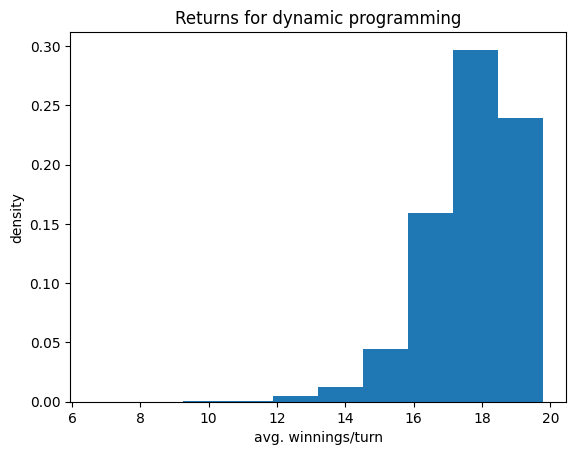

In [12]:
res_dp = simulate(dp_strat, n_turns=100, n_sims=10000, verbose=True)
plt.hist(res_dp, 10, density=True)
plt.ylabel("density")
plt.xlabel("avg. winnings/turn")
plt.title(f"Returns for dynamic programming")
print(f"Avg. winnings: {np.mean(res_dp):.3f}")

## Comparison

100%|██████████| 1000/1000 [00:03<00:00, 295.13it/s]


Avg. DP strat returns:          17.72833
Avg. threshold strat returns:   17.72316


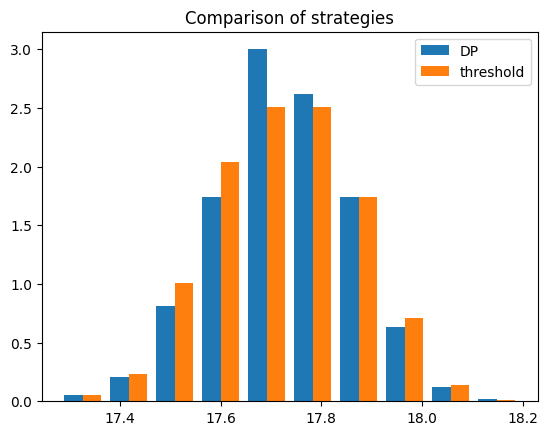

In [21]:
res_thresh = []
res_dp = []

# Run 10 trials for each strategy
for _ in tqdm(range(1000)):
    mean = np.mean(simulate(lambda top, _: top >= 18, n_turns=100, n_sims=100))
    res_thresh.append(mean)
for _ in tqdm(range(1000)):
    mean = np.mean(simulate(dp_strat, n_turns=100, n_sims=100))
    res_dp.append(mean)

plt.hist([res_dp, res_thresh], label=["DP", "threshold"], density=True)
plt.title("Comparison of strategies")
plt.legend()

print(f"Avg. DP strat returns:          {np.mean(res_dp):.5f}")
print(f"Avg. threshold strat returns:   {np.mean(res_thresh):.5f}")